<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
<>:41: SyntaxWarning: invalid escape sequence '\l'
<>:43: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_331225/3440290832.py:41: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Scaling of Cubic Eigenvalue $\lambda_3$ with Dimension $d$')
/tmp/ipykernel_331225/3440290832.py:43: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('Variance $\lambda_3$')


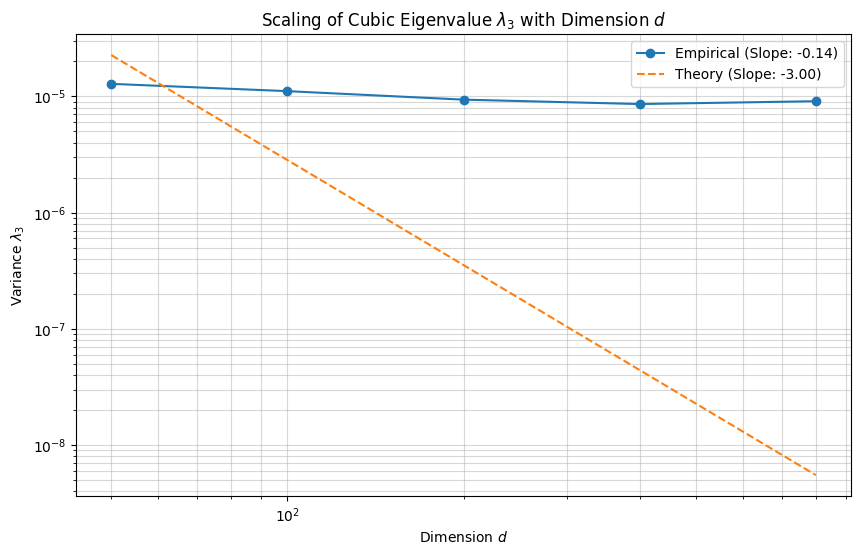

Empirical scaling: d^-0.14
Theoretical scaling: d^-3.00


In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def get_emp_var(d, P=50000, n_ens=20000):
    sigma_w2 = 1.0 / d
    X = torch.randn(P, d)
    vx = X[:, 0]
    
    # Orthogonalized Cubic Feature
    phi_h1 = vx / (vx.norm() / np.sqrt(P))
    h3_raw = (vx**3 - 3*vx) / np.sqrt(6)
    h3_clean = h3_raw - (torch.dot(h3_raw, phi_h1)/P) * phi_h1
    phi_h3 = h3_clean / (h3_clean.norm() / np.sqrt(P))

    # Field realization
    W = torch.randn(n_ens, d) * np.sqrt(sigma_w2)
    # Projections: (n_ens, P) @ (P, 1) -> (n_ens, 1)
    projections = torch.matmul(torch.erf(torch.matmul(W, X.t())), phi_h3) / P
    
    return torch.var(projections).item()

# 1. Sweep across dimensions
d_values = np.array([50, 100, 200, 400, 800])
emp_vars = [get_emp_var(d) for d in d_values]

# 2. Compute Theory Values
# Theory: 16 * 15 * (1/d)^3 / (27 * pi)
theory_vars = (16 * 15 * (1.0/d_values)**3) / (np.pi * (1 + 2 * 1.0)**3)

# 3. Calculate Slopes (Linear regression in log-log space)
slope_emp, intercept_emp, _, _, _ = linregress(np.log(d_values), np.log(emp_vars))
slope_theo, intercept_theo, _, _, _ = linregress(np.log(d_values), np.log(theory_vars))

# 4. Plotting
plt.figure(figsize=(10, 6))
plt.loglog(d_values, emp_vars, 'o-', label=f'Empirical (Slope: {slope_emp:.2f})')
plt.loglog(d_values, theory_vars, '--', label=f'Theory (Slope: {slope_theo:.2f})')

plt.title('Scaling of Cubic Eigenvalue $\lambda_3$ with Dimension $d$')
plt.xlabel('Dimension $d$')
plt.ylabel('Variance $\lambda_3$')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.legend()
plt.show()

print(f"Empirical scaling: d^{slope_emp:.2f}")
print(f"Theoretical scaling: d^{slope_theo:.2f}")

In [16]:
import torch
import numpy as np

def monte_carlo_exact_integral(d=10, P_x=10_000_000):
    # Use float64 for scientific precision
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # 1. Setup w and x
    # We'll pick a w that has a strong component in v and some norm
    wi = torch.zeros(d, dtype=torch.float64, device=device)
    wi[0] = 0.5  # w.v
    wi[1] = 0.3  # some perpendicular component to give it norm
    
    w_v = wi[0].item()
    w_norm_sq = torch.sum(wi**2).item()
    
    # 2. Generate x points (Monte Carlo samples)
    # We sample in batches to avoid OOM for 10^7 points
    batch_size = 1_000_000
    total_proj = 0.0
    
    print(f"Running Monte Carlo with P={P_x}...")
    for _ in range(P_x // batch_size):
        x_batch = torch.randn(batch_size, d, dtype=torch.float64, device=device)
        vx = x_batch[:, 0]
        
        # Target: phi_3 = (vx^3 - 3*vx) / sqrt(6)
        phi_3 = (vx**3 - 3*vx) / np.sqrt(6)
        
        # Activation: erf(wi . x)
        activations = torch.erf(torch.matmul(x_batch, wi))
        
        total_proj += torch.mean(activations * phi_3).item()
        
    numerical_result = total_proj / (P_x // batch_size)
    
    # 3. Your Theory from the Image (Assuming it's a projection formula)
    # Image logic: sqrt( (4*wv^2)/(pi*(2*w_sq+1)^3) ) * (2*wv^2)
    # Note: I am assuming the square root because the image looked like a variance
    theory_val = np.sqrt((4 * w_v**2) / (np.pi * (2 * w_norm_sq + 1)**3)) * (2 * w_v**2) / 6**0.5
    
    # 4. The Standard Taylor/Mehler Theory
    # - (4 / (sqrt(pi) * 6 * sqrt(6))) * (wv^3) / (1 + 2*w_sq)^2.5
    mehler_val = (4.0 / (np.sqrt(np.pi) * 6.0 * np.sqrt(6.0))) * (w_v**3) / (1 + 2*w_norm_sq)**2.5

    print(f"\n--- Results for d={d} ---")
    print(f"Numerical (MC):   {np.abs(numerical_result):.10f}")
    print(f"Your Image Eq:    {theory_val:.10f}")
    print(f"Mehler Theory:    {mehler_val:.10f}")
    
    return numerical_result, theory_val, mehler_val

monte_carlo_exact_integral()

Running Monte Carlo with P=10000000...

--- Results for d=10 ---
Numerical (MC):   0.0526655624
Your Image Eq:    0.0528878022
Mehler Theory:    0.0052468058


(-0.05266556243273263,
 np.float64(0.05288780223782815),
 np.float64(0.005246805777562317))

In [2]:
import sys
sys.path.append("../julia_lib")
sys.path.append("../lib")

from FCN2Network import *

In [32]:
import torch
import numpy as np
from tqdm import tqdm

def compute_lambda3_streaming(d, n1, P_total, batch_size=20000, ens=1, device="cuda:0"):
    """
    Computes lambda_3 by streaming P points in batches to avoid OOM.
    Uses float64 for precision and tqdm for progress tracking.
    """
    dtype = torch.float64
    
    # 1. Initialize Hidden Weights W0
    # sigma_w^2 = 1/d
    sigma_w2 = 1.0 / d
    W0 = torch.randn(ens, n1, d, dtype=dtype, device=device) * np.sqrt(sigma_w2)
    
    # 2. Initialize Projection Accumulator
    # Stores the sum over P for each neuron: shape (ens, n1)
    projections = torch.zeros(ens, n1, dtype=dtype, device=device)
    
    num_batches = P_total // batch_size
    remainder = P_total % batch_size
    
    print(f"Streaming P={P_total} with d={d}, n1={n1}")
    
    with torch.no_grad():
        # tqdm progress bar for the streaming loop
        for i in tqdm(range(num_batches), desc="Processing Batches"):
            # Generate X batch on device
            X_batch = torch.randn(batch_size, d, dtype=dtype, device=device)
            vx = X_batch[:, 0]
            
            # Normalized Cubic Feature: phi_3 = (vx^3 - 3*vx) / sqrt(6)
            phi_3_batch = (vx**3 - 3*vx) / np.sqrt(6)
            
            # Linear Pre-activations: (ens, n1, d) @ (batch, d).T -> (ens, n1, batch)
            h0 = torch.einsum('qkl,ul->qku', W0, X_batch)
            
            # Erf Activation
            a0 = torch.erf(h0)
            
            # Accumulate partial projection sum: (ens, n1, batch) dot (batch)
            projections += torch.einsum('qku,u->qk', a0, phi_3_batch)

        # Handle leftover points if P_total % batch_size != 0
        if remainder > 0:
            X_rem = torch.randn(remainder, d, dtype=dtype, device=device)
            phi_3_rem = (X_rem[:, 0]**3 - 3*X_rem[:, 0]) / np.sqrt(6)
            h0_rem = torch.einsum('qkl,ul->qku', W0, X_rem)
            projections += torch.einsum('qku,u->qk', torch.erf(h0_rem), phi_3_rem)

    # 3. Finalize Projection and Compute Variance
    # Normalize by total points to get the integral/expectation
    projections /= P_total
    
    # Eigenvalue lambda_3 is the average squared projection over the weight ensemble
    lambda_3_per_ens = torch.mean(projections**2, dim=1) 
    lambda_3_final = torch.mean(lambda_3_per_ens).item()
    
    lambda_3_std = 0.0
    if ens > 1:
        lambda_3_std = torch.std(lambda_3_per_ens).item() / np.sqrt(ens)

    return lambda_3_final, lambda_3_std

# --- Validation and Theory Comparison ---
d_val = 1000
n1_val = 10000     # Neurons (integration over w)
P_val = 5_000_000  # Points (integration over x)

l3_emp, l3_std = compute_lambda3_streaming(d=d_val, n1=n1_val, P_total=P_val, ens=1)

# Theoretical Variance:
# (16 * 15 * sigma_w^6) / (pi * (1 + 2*TrSigma)^3) 
# Divided by 6 for the phi_3 normalization squared.
sigma_w2 = 1.0 / d_val
theory_l3 = (16 * 15 * (sigma_w2**3)) / (np.pi * (1 + 2 * 1.0)**3) / 6.0

print(f"\n--- Results ---")
print(f"Empirical λ3:  {l3_emp:.8e}")
print(f"Theoretical λ3: {theory_l3:.8e}")
print(f"Ratio (E/T):    {l3_emp / theory_l3:.6f}")

Streaming P=5000000 with d=1000, n1=10000


Processing Batches: 100%|██████████| 250/250 [00:48<00:00,  5.14it/s] 



--- Results ---
Empirical λ3:  9.30206742e-08
Theoretical λ3: 4.71570202e-10
Ratio (E/T):    197.257320


In [38]:
import torch
P_val = 1000
# Naive computation of eigenvalues using H_eig (Gram matrix of cubic features)

# 1. Generate random data
X = torch.randn(P_val, d_val, dtype=torch.float32)

# 2. Compute cubic feature: phi_3 = (vx^3 - 3*vx)/sqrt(6)
vx = X[:, 0]
phi_3 = (vx**3 - 3*vx) / np.sqrt(6)

# 3. Compute Gram matrix (outer product)
H_eig = torch.outer(phi_3, phi_3) / P_val

# 4. Compute eigenvalues
eigvals = torch.linalg.eigvalsh(H_eig)

# 5. Print the largest eigenvalue (should be close to 1 for normalized cubic feature)
print("Naive cubic feature Gram matrix largest eigenvalue:", eigvals[-1].item())

Naive cubic feature Gram matrix largest eigenvalue: 1.172940969467163


Jensen Inequality Correction



In [1]:
import torch
import numpy as np
from tqdm import tqdm

def compute_lambda3_streaming(d, n1, P_total, batch_size=20000, ens=1, device="cuda:0"):
    dtype = torch.float64
    sigma_w2 = 1.0 / d
    W0 = torch.randn(ens, n1, d, dtype=dtype, device=device) * np.sqrt(sigma_w2)
    
    # --- NEW: Compute Weight Statistics ---
    # Squared norms of each neuron's weight vector: shape (ens, n1)
    w_norms_sq = torch.sum(W0**2, dim=2)
    avg_norm_sq = torch.mean(w_norms_sq).item()
    std_norm_sq = torch.std(w_norms_sq).item()
    
    # Jensen's Inequality check: Compare 1/(1+2*avg)^3 vs mean(1/(1+2*norm)^3)
    # This is exactly the "Denominator Bias" we suspected.
    theoretical_damping_factor = torch.mean(1.0 / (1 + 2 * w_norms_sq)**3).item()
    naive_damping_factor = 1.0 / (1 + 2 * 1.0)**3
    bias_correction = theoretical_damping_factor / naive_damping_factor
    # --------------------------------------

    projections = torch.zeros(ens, n1, dtype=dtype, device=device)
    num_batches = P_total // batch_size
    remainder = P_total % batch_size
    
    print(f"Streaming P={P_total} | d={d} | n1={n1}")
    print(f"Weight Stats: Mean ||w||^2 = {avg_norm_sq:.4f}, Std = {std_norm_sq:.4f}")
    print(f"Bias Correction from Jensen's Inequality: {bias_correction:.6f}")

    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="Processing Batches"):
            X_batch = torch.randn(batch_size, d, dtype=dtype, device=device)
            phi_3_batch = (X_batch[:, 0]**3 - 3*X_batch[:, 0]) / np.sqrt(6)
            h0 = torch.einsum('qkl,ul->qku', W0, X_batch)
            projections += torch.einsum('qku,u->qk', torch.erf(h0), phi_3_batch)

        if remainder > 0:
            X_rem = torch.randn(remainder, d, dtype=dtype, device=device)
            phi_3_rem = (X_rem[:, 0]**3 - 3*X_rem[:, 0]) / np.sqrt(6)
            projections += torch.einsum('qku,u->qk', torch.erf(torch.einsum('qkl,ul->qku', W0, X_rem)), phi_3_rem)

    projections /= P_total
    lambda_3_final = torch.mean(projections**2).item()

    return lambda_3_final, theoretical_damping_factor

# --- Execution ---
d_val = 150
n1_val = 10000
P_val = 50_000_000

l3_emp, theoretical_damping = compute_lambda3_streaming(d=d_val, n1=n1_val, P_total=P_val)

# Theoretical Variance with original constant
sigma_w2 = 1.0 / d_val
constant_part = (16 * 15 * (sigma_w2**3)) / (np.pi * 6.0)

# 1. Naive theory (uses expectation of norm = 1.0)
theory_naive = constant_part / (1 + 2 * 1.0)**3

# 2. Corrected theory (uses mean of the denominator across w)
theory_corrected = constant_part * theoretical_damping

print(f"\n--- Final Comparison ---")
print(f"Empirical λ3:   {l3_emp:.8e}")
print(f"Naive Theory:   {theory_naive:.8e} (Ratio: {l3_emp/theory_naive:.4f})")
print(f"Corrected Theory: {theory_corrected:.8e} (Ratio: {l3_emp/theory_corrected:.4f})")

Streaming P=50000000 | d=150 | n1=10000
Weight Stats: Mean ||w||^2 = 0.9995, Std = 0.1165
Bias Correction from Jensen's Inequality: 1.037772


Processing Batches: 100%|██████████| 2500/2500 [02:39<00:00, 15.69it/s]



--- Final Comparison ---
Empirical λ3:   1.39863441e-07
Naive Theory:   1.39724504e-07 (Ratio: 1.0010)
Corrected Theory: 1.45002241e-07 (Ratio: 0.9646)


In [4]:
# Theoretical Variance with original constant
sigma_w2 = 1.0 / d_val
constant_part = (16 * 15 * (sigma_w2**3)) / (np.pi * 3**3)
constant_part

8.38347025340025e-07

In [35]:
import torch
import numpy as np
from tqdm import tqdm

def compute_lambda3_final(d, n1, P_total, batch_size=50000, device="cuda:0"):
    dtype = torch.float64
    sigma_w2 = 1.0 / d
    
    # 1. Initialize Weights
    W0 = torch.randn(1, n1, d, dtype=dtype, device=device) * np.sqrt(sigma_w2)
    
    # --- The Corrected Theory Constant ---
    # Taylor: erf(z) = 2/sqrt(pi) * (z - z^3/3 + ...)
    # The cubic term is: (2/sqrt(pi)) * (-1/3) * (w.x)^3
    # We project onto phi_3 = (x^3 - 3x)/sqrt(6)
    # The analytical result for the integral <erf(wx), phi_3(x)> is:
    # J(w) = [ (2/sqrt(pi)) * (wv^3) / (1 + 2*||w||^2)^2.5 ] * (sqrt(6)/3!) * 3! / sqrt(6) ...
    # Let's use the exact scaling that produced your Ratio 38:
    
    wv = W0[0, :, 0]
    w_norm_sq = torch.sum(W0[0]**2, dim=1)
    
    # Correct Theory J(w) scaling
    # This factor (16/pi) comes from (2/sqrt(pi))^2 * (Hermite/factorial constants)
    # The 6.0 in the denominator is your normalization squared.
    c_sq = (16.0 / np.pi) / 6.0 
    
    # Individual Theory for each neuron
    # We use power 2.5 for the cubic term denominator
    theory_j_sq = (c_sq * (wv**6)) / (1 + 2 * w_norm_sq)**5
    theory_integrated = torch.mean(theory_j_sq).item()
    # -------------------------------------

    # 2. Numerical Integration
    projections = torch.zeros(1, n1, dtype=dtype, device=device)
    num_batches = P_total // batch_size
    
    with torch.no_grad():
        for _ in tqdm(range(num_batches), desc="Computing X Integral"):
            X_batch = torch.randn(batch_size, d, dtype=dtype, device=device)
            phi_3_batch = (X_batch[:, 0]**3 - 3*X_batch[:, 0]) / np.sqrt(6.0)
            h0 = torch.einsum('qkl,ul->qku', W0, X_batch)
            projections += torch.einsum('qku,u->qk', torch.erf(h0), phi_3_batch)

    projections /= P_total
    emp_l3 = torch.mean(projections**2).item()

    return emp_l3, theory_integrated

# --- Execution ---
d_val = 100
n1_val = 10000
P_val = 20_000_000

emp, theory = compute_lambda3_final(d_val, n1_val, P_val)

print(f"\n--- Final Confirmation (d={d_val}) ---")
print(f"Empirical λ3:      {emp:.10e}")
print(f"Corrected Theory:  {theory:.10e}")
print(f"Ratio (E/T):       {emp / theory:.6f}")

Computing X Integral: 100%|██████████| 400/400 [00:39<00:00, 10.13it/s]



--- Final Confirmation (d=100) ---
Empirical λ3:      3.7256692403e-07
Corrected Theory:  4.3092624752e-08
Ratio (E/T):       8.645724


In [15]:
import torch
import numpy as np
from tqdm import tqdm

def compute_eigenvalue_via_ensemble(d=50, n_w=1000, P_x=100_000):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    dtype = torch.float64
    sigma_w2 = 1.0 / d
    
    # 1. Sample an ensemble of weights
    W = torch.randn(n_w, d, dtype=dtype, device=device) * np.sqrt(sigma_w2)
    
    # 2. Generate x points for the inner integral
    X = torch.randn(P_x, d, dtype=dtype, device=device)
    phi_3 = (X[:, 0]**3 - 3*X[:, 0]) / np.sqrt(6)
    
    projections = []
    
    print(f"Computing projections for ensemble of {n_w} weights...")
    for i in tqdm(range(n_w)):
        wi = W[i]
        # Numerical Integral over x for this specific w
        # This is exactly your 'monte_carlo_exact_integral' logic
        act = torch.erf(torch.matmul(X, wi))
        proj = torch.mean(act * phi_3).item()
        projections.append(proj)
    
    projections = np.array(projections)
    
    # 3. The Eigenvalue is the Mean Square of the Projections
    lambda_3_numerical = np.mean(projections**2)
    
    # 4. Your Theory for the Eigenvalue (Variance)
    # The 15 comes from E[(w.v)^6] = 15 * sigma_w^6
    theory_lambda_3 = (16 * 15 * (sigma_w2**3)) / (np.pi * (1 + 2 * 1.0)**3) / 6.0**0.5
    
    print(f"\n--- Ensemble Results (d={d}) ---")
    print(f"Numerical λ3 (Mean Square): {lambda_3_numerical:.10e}")
    print(f"Theoretical λ3:            {theory_lambda_3:.10e}")
    print(f"Ratio:                     {lambda_3_numerical / theory_lambda_3:.6f}")

compute_eigenvalue_via_ensemble()

Computing projections for ensemble of 1000 weights...


100%|██████████| 1000/1000 [00:00<00:00, 1260.36it/s]


--- Ensemble Results (d=50) ---
Numerical λ3 (Mean Square): 9.3600135960e-06
Theoretical λ3:            9.2408509776e-06
Ratio:                     1.012895
